# Basic Training

In this notebook, we'll train some basic Random Forests and look at various hyperparameters.

# Setup

## Imports

In [1]:
from utils import * # Loads all the necessary utilities needed for the competition

## Useful Features

In [2]:
jtplot_style()

Sets the data of the training function for repeated training

In [3]:
def set_data(data):
    global train_model
    from functools import partial
    train_model = partial(train_model, data=data)

## Create Training Set

In [4]:
data = feather.read_dataframe(DIR_DATA / 'train.ft') # Load the preprocessed feather file

`proc_df()` processes the dataframe in many different ways, making it suitable for training and inference.

In this case, it:
* dissociates the dependent variable, `'price_doc'` and puts it into `y`
* replaces the missing/NA values by the median of the column and stores it into `nas`
* changes categories into numbers
* samples from the data

Note that we'll sample 5000 datapoints (about $\frac{1}{5}$ of the data) in order to speed things up. You'll want to do this when you're exploring and want to do so quickly.

In [5]:
x, y, nas = proc_df(data, 'price_doc', subset=5000)

In [6]:
x.head().T.show()

1            4   \
id                                                  2            5   
full_sq                                            34           77   
life_sq                                            19           77   
floor                                               3            4   
max_floor                                          12           12   
material                                            1            1   
build_year                                       1980         1980   
num_room                                            2            2   
kitch_sq                                            6            6   
state                                               2            2   
product_type                                        1            1   
sub_area                                           71            7   
area_m                                    9.58934e+06  8.39846e+06   
raion_popul                                    115352       108171   
green_zone_part                              0.372602    0.0152337   
indust_part                                 0.0496373    0.0373165   
children_preschool                               6880         5706   
preschool_quota                                  3119         3240   
preschool_education_centers_raion                   5            7   
children_school                                  7759         6748   
school_quota                                     6237         7770   
school_education_centers_raion                      8            9   
school_education_centers_top_20_raion               0            0   
hospital_beds_raion                               229          562   
healthcare_centers_raion                            1            4   
university_top_20_raion                             0            2   
sport_objects_raion                                 6           25   
additional_education_raion                          1            2   
culture_objects_top_25                              2            1   
culture_objects_top_25_raion                        1            0   
shopping_centers_raion                              3           10   
office_raion                                        0           93   
thermal_power_plant_raion                           1            1   
incineration_raion                                  1            1   
oil_chemistry_raion                                 1            1   
radiation_raion                                     1            2   
railroad_terminal_raion                             1            2   
big_market_raion                                    1            1   
nuclear_reactor_raion                               1            1   
detention_facility_raion                            1            1   
full_all                                        76284        28179   
male_f                                          34200        13522   
female_f                                        42084        14657   
young_all                                       15727        13368   
young_male                                       7925         7159   
young_female                                     7802         6209   
work_all                                        70194        68043   
work_male                                       35622        34236   
work_female                                     34572        33807   
ekder_all                                       29431        26760   
ekder_male                                       9266         8563   
ekder_female                                    20165        18197   
0_6_all                                          6880         5706   
0_6_male                                         3466         2982   
0_6_female                                       3414         2724   
7_14_all                                         7759         6748   
7_14_male                                        3909        

# Train Model

We train using a simple model called a Random Forest

In [7]:
model = RandomForestRegressor(n_estimators=10, n_jobs=-1)

Train it and see the root mean squared error (RMSE) as well as the $R^2$ value, which is just a measure of the goodness of fit

In [8]:
model.fit(x, y)
print('r^2: {:.4f}, RMSE: {:.4f}'.format(*model.eval(x, y)))

r^2: 0.8830, RMSE: 0.0424


That's really good! Too good!

In fact that places us right at the top of the rankings!!!

Numero Uno, baby! Yeah!
<br><br>
Not quite...

## Split into Validation Set

What we essentially did was the same as preparing for an exam by studying a book...
and then having the same questions somehow miraculously appearing in the exam 😉

You should know how often this happens in India, btw 😏

What we need to do instead, is to hold out some of our training data into a sepearate set called the _validation set_

This set is basically unseen by the model and it can only return predictions on it.
i.e. The training set is exclusively used for training and the validation set is exclusively used for judging how good the model actually is on data it's never seen before.

In [9]:
# We split of 20% of x and y into validation sets x_val and y_val
(x, y), (x_val, y_val) = split_val(x, y, frac=0.2)

In [10]:
set_data(((x, y), (x_val, y_val))) # Sets the data the train_model() function will work with

In [11]:
model, mets = train_model(RandomForestRegressor(10, n_jobs=-1), metrics=True)

Training - r^2: 0.8688, RMSE: 0.0476
Validation - r^2: 0.3338, RMSE: 0.2320


Oh, phooey 😔

When our model is asked some tough, never-before-seen questions, it does worse.

As expected.

We get an $R^2$ of just {{f'{mets[1][0]:.2f}'}} against the previous {{f'{mets[0][0]:.2f}'}} for the training set.

That is an ginormous difference of {{f'{(mets[0][0] - mets[1][0]):.2f}'}}
<br><br>
This kind of bad _performance in the "exams"_ is called **overfitting**.

## Single Tree

The Random Forest - as the name suggests - is just that... a forest!
<br><br>
Surely, this forest consists of many _trees_.
<br><br>
Our current model consists of 10 such trees.

Let's now take a look at a single tree

In [12]:
# A single tree
# Ignore the other arguments for the moment
model = train_model(RandomForestRegressor(1, max_depth=3, bootstrap=False, n_jobs=-1))

Training - r^2: 0.3116, RMSE: 0.2497
Validation - r^2: 0.3451, RMSE: 0.2280


Intuitively, we would have guessed that a single tree's performance wouldn't quite stack up against an _ensemble_ of 10 trees. And that is exactly what has happened.

Nonetheless, let's just draw this tree out and see what it's doing.

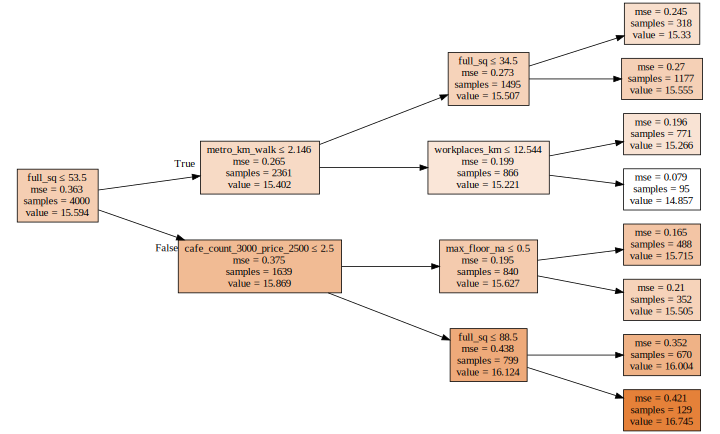

In [13]:
tree = model.estimators_[0] # Get the first and only estimator (tree) of the model
draw_tree(tree, x, precision=3)

In [14]:
nodes = get_nodes(tree, x)

Let's walk through what's the tree has _learned_.
<hr>

1. First, it's chosen the {{nodes[0].q}} column.

2. Now, it asks: "Which are the points where {{nodes[0].q}} is less than or equal to {{nodes[0].t}}?"

3. It seperates the dataset into these two subsets.

4. For the first subset ({{nodes[0].q}} $\leq$ {{nodes[0].t}}), it then repeats steps 1-3 like so:

 * It choses the {{nodes[1].q}} column.
 
 * It asks: "Which are the points where {{nodes[1].q}} is less than or equal to {{nodes[1].t}}?"
 
 * It seperates the dataset into these two further subsets.
 
5. Similarly, for the second subset ({{nodes[0].q}} $\geq$ {{nodes[0].t}}), it then repeats steps 1-3 like so:

 * It choses the {{nodes[2].q}} column.
 
 * It asks: "Which are the points where {{nodes[2].q}} is less than or equal to {{nodes[2].t}}?"
 
 * It seperates the dataset into these two further subsets.
 
We see that the entire tree is just a result of recursive applications of steps 1-3.

The tree can be, of course, built up until some terminating conditions like the maximum number of datapoints in the subset (after which it's further _indivisible_), the maximum depth etc.
<hr>

The question now, is this:

_"How's this tree built in the first place? Where does the data come in?
Where's the Machine Learning?"_

Let's think about the following points of the algorithm:
<br>

* We start with our _parent/root_ node which has the entire dataset.

* If we're at a given node, we'll **predict the mean** of it's associated dataset.

* With such a prediction, we'll also get an associated error (in this case, the RMSE).

* For each node, we might make a split at a certain point of a certain feature.
 This will divide the node's dataset across two _child_ nodes.
 
* We can produce children until some conditions are met (ensure maximum number of datapoints in the node etc.)

* After the tree is built, we make a prediction by passing each datapoint through the parent node, and following a path as appropriate until we reach a _terminal/leaf_ node.
 Our prediction will be the _value/mean_ of this node.
<br><br>

Now, it's only a question of how to split...
<br><br>
i.e. For each node, which column to chose and what value of that column to split at?
<hr>

Well, since we want the error to reduce,...

a well-meaning split should reduce the error.

But, we can't just add up the errors of the two children since they can contain a different number of datapoints each.

So, here, the first node has error {{f'{nodes[0].e:.2f}'}} and the second and third have errors {{f'{nodes[1].e:.2f}'}} and {{f'{nodes[2].e:.2f}'}} respectively. The addition ({{f'{(nodes[1].e + nodes[2].e):.2f}'}}), could conceivably be higher.
<br><br>
Instead, **we take the weighted average of the errors of the two children, weighted by their number of datapoints**.

So, here, _({{f'{nodes[1].s}'}} * {{f'{nodes[1].e:.2f}'}} + {{f'{nodes[2].s}'}} * {{f'{nodes[2].e:.2f}'}}) / ({{f'{nodes[1].s}'}} + {{f'{nodes[2].s}'}}) = {{f'{((nodes[1].s * nodes[1].e + nodes[2].s * nodes[2].e) / (nodes[1].s + nodes[2].s)):.2f}'}}_

which is less than the parent node's error.
<br><br>
**we literally take EVERY SINGLE COLUMN AND EVERY POSSIBLE VALUE TO SPLIT ON and try it out**.

Whichever combination reduces the error the most wins!

### Bigger Tree

In the previous example, we cut the tree of at the third layer via `max_depth=3`.

Now, let's build the tree fully.

In [15]:
model, mets = train_model(RandomForestRegressor(1, bootstrap=False, n_jobs=-1),
                             metrics=True)

Training - r^2: 1.0000, RMSE: 0.0000
Validation - r^2: -0.3312, RMSE: 0.4635


<h5>Woah! Woah! Woah!</h5>

The training error is exactly 0!

i.e. Our single tree is enough to predict the _entire_ dataset correctly.
<br><br>
Of course, this should be no surprise if we think about it.

The tree continues splitting and growing until the leaf nodes have a single datapoint (or all datapoints have the same value).

So, all the leaf nodes in this tree have precisely 0 error!
<hr>
Unfortunately, though, this single tree is not the ultimate terminator AI which can predict the future because it overfits...
<br><br>
badly.
<br><br>
(Validation $R^2$ {{f'{mets[1][0]:.2f}'}} as against a perfect training $R^2$ of 1)

btw. If $R^2$ is negative, then it means we'd be better of predicting the mean! 😳

Warning: Life-lesson follows
---------------------------------------------
This sort of extreme overfitting is because, in it's quest for absolute perfection and getting every single thing exactly right, the model fit the _noise_ in the data.

That's right folks. The world isn't perfect. It's a cold world out there. People are wrong all the time. The data isn't 100% foolproof and so should'nt our models be.

The little mistakes in what we know about our world can make us see it for what it isn't.

Like the proverbial Blind Men and the Elephant.

![blindmenelephant](assets/elephant.jpeg)



We need the all the men. Different points of view.
<br><br>
We need an **ensemble**.

## Bagging

We train 10 trees on the model and then average their predictions.

If the trees are not _correlated_ to each other, then their individual errors should cancel each other, much like the blind men above.

In [16]:
model = train_model(RandomForestRegressor(10, bootstrap=False, n_jobs=-1))

Training - r^2: 1.0000, RMSE: 0.0000
Validation - r^2: -0.1664, RMSE: 0.4061


Slightly better.

But we're missing a crucial piece of the puzzle...
<br><br>
**Bootstrapping**

Imagine that the datapoints are little balls placed inside a bag.

Suppose there's a 10 of them.

Ordinarily, we would take these balls one by one and keep them in our parent node.

Instead, here, we take a ball, and keep _a copy_ of the ball in our parent node and put it back.

This way, we get 10 balls in our root node as before, but now they are copies and more than one copy of a ball may be present.

For example, take a set of these 10 numbers/datapoints: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Without bootstrapping, ordinarily, our root node will contain these 10 numbers as is.

With bootstrapping, we sample 10 items from this set _with replacement_:

(0, 5, 3, 5, 7, 6, 2, 4, 8, 1)
<br><br>
Notice that 5 has appeared twice, and that's okay.

The huge upside with this technique is that each tree is now _seeing a different dataset_, virtually.

This means that there's less _correlation_ between the trees.

So, without bootstrapping, it was like the blind men were all touching at the elephant's tail and said it was a rope.

Now, they are at different angles, and have something different to add.
<br><br>
Let's try it out

In [17]:
model = train_model(RandomForestRegressor(10, n_jobs=-1))

Training - r^2: 0.8716, RMSE: 0.0466
Validation - r^2: 0.2772, RMSE: 0.2517


There we go!

An small step for man but a giant leap for mankind.

Let's take a look at the individual predictions for the 10 trees.

In [19]:
preds = np.stack([tree.predict(x_val) for tree in model.estimators_])
preds[:, 0], preds[:, 0].mean(), y_val[0]

(array([15.2018 , 15.73243, 13.81551, 15.75614, 14.50866, 15.5989 , 14.64842, 13.81551, 15.71013, 15.67181]),
 15.045930969851366,
 14.914122846632385)

Some predictions are lower than the true value while some are higher.
Which is what we need.

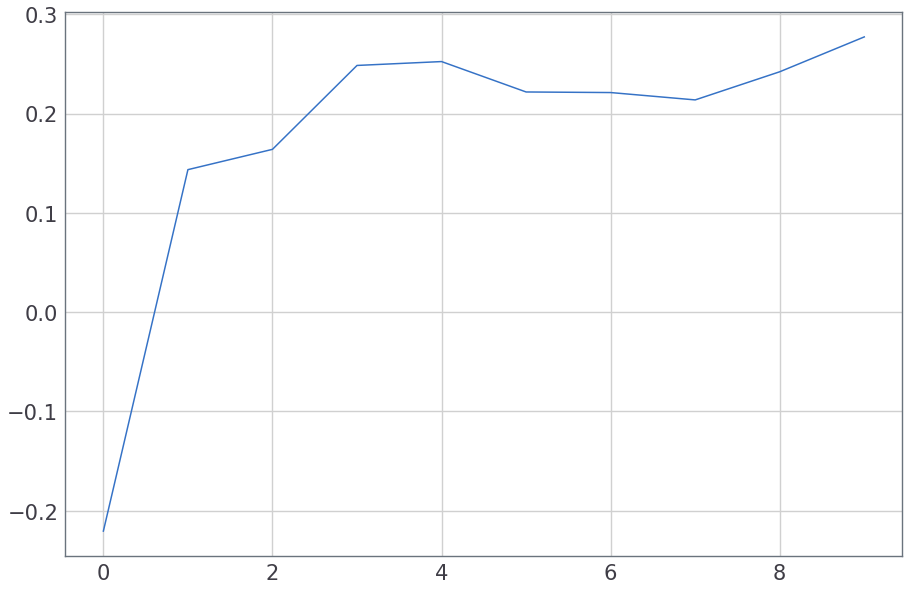

In [20]:
plot([metrics.r2_score(y_val, np.mean(preds[:i+1], axis=0)) for i in range(10)])

In the plot above, we see that as we consider more trees, the $R^2$ goes up.

After a certain point though, returns diminish.

## More Trees

Let's successively try more trees like above.

In [21]:
model = train_model(RandomForestRegressor(20, n_jobs=-1))

Training - r^2: 0.8922, RMSE: 0.0391
Validation - r^2: 0.3641, RMSE: 0.2214


In [22]:
model = train_model(RandomForestRegressor(40, n_jobs=-1))

Training - r^2: 0.9017, RMSE: 0.0356
Validation - r^2: 0.3847, RMSE: 0.2143


In [23]:
model = train_model(RandomForestRegressor(80, n_jobs=-1))

Training - r^2: 0.9068, RMSE: 0.0338
Validation - r^2: 0.3876, RMSE: 0.2132


## Out-Of-Bag Error

We also have a clever technique called the Out-Of-Bag score.

For each tree, we run predictions on the columns of the dataset that were not included in it's training.

So, in some sense, it's a psuedo-validation set.

In [24]:
model = train_model(RandomForestRegressor(40, n_jobs=-1, oob_score=True))

Training - r^2: 0.9000, RMSE: 0.0363
Validation - r^2: 0.3729, RMSE: 0.2183
oob: 0.2989


Note that the OOB Score may be lower than the validation RMSE in this case since we took time-based ordering when splitting the validation set.

## Subsampling

Remember that we're running this on a sample set of length 5000 (4000 training + 1000 validation) to make our experiments zippy?
<br><br>
Well, what if instead of sampling in the beginning, we sample for each tree?

This technique is called subsampling.

In [25]:
x, y, nas = proc_df(data, 'price_doc')
(x, y), (x_val, y_val) = split_val(x, y, frac=0.2)

In [26]:
set_rf_samples(5000) # Supported out of the box by the FastAI library

In [27]:
model = train_model(RandomForestRegressor(40, n_jobs=-1, oob_score=True))

Training - r^2: 0.9380, RMSE: 0.0225
Validation - r^2: 0.3738, RMSE: 0.2180
oob: 0.2591


## Other Hyperparameters

The `min_samples_leaf` value dictates how many samples are _atomic_/indivisible. As soon as a node has these many samples or less, it's declared a leaf node.

Usually, this is set to $1$.

Each time we double it, the number of leaf nodes halves and the depth of the tree decrements.
We get a more stable average.

This leads to a less predictive tree but the trees are less correleated.

In [28]:
model = train_model(RandomForestRegressor(40, min_samples_leaf=3, n_jobs=-1, oob_score=True))

Training - r^2: 0.8524, RMSE: 0.0535
Validation - r^2: 0.4047, RMSE: 0.2073
oob: 0.3074


`max_features` dictates the number of features to search for in finding a split.

If not $1$ (default), it randomly selects those many features and finds the best split among those features.

Consider a scenario where some single feature turns out to be super predictive and all the trees of our forest initially split on that column. That's going to be a boring forest, all right.

Instead, this bit of randomness allows each tree to explore and learn something different and have an alternative perspective on <del>life</del> data.

In [29]:
model = train_model(RandomForestRegressor(40,  min_samples_leaf=3, n_jobs=-1,
                                          max_features=0.5, oob_score=True))

Training - r^2: 0.8417, RMSE: 0.0574
Validation - r^2: 0.4330, RMSE: 0.1974
oob: 0.3049


# Final Model

We'll just select the best model after _tuning_ the above _hyperparameters_ and save it.

In [30]:
reset_rf_samples() # Take the full dataset

In [31]:
model = train_model(RandomForestRegressor(40, min_samples_leaf=25,
                                          n_jobs=-1, max_features=0.5))

Training - r^2: 0.5150, RMSE: 0.1759
Validation - r^2: 0.4473, RMSE: 0.1924


In [32]:
joblib.dump(model, DIR_CHECKPOINTS / 'model.p') # Save Model

['/home/vaisakh/Kaggle/sberbank/Checkpoints/model.p']